# 1. Overview

This is a notebook for training models to submit predictions to the "Predicting the Beats-per-Minute of Songs" Kaggle competition ([playground-series-s5e9](https://www.kaggle.com/competitions/playground-series-s5e9)).

Synthetic data is used for this playground competition, and the objective is to, for each song (with a corresponding `id`) in the test set, predict the beats per minute for it.

# 2. Setup

Let's first do some initial setup to import what we'll need, and set some configurations that will make it easier to check the output.

In [1]:
import numpy as np
import pandas as pd
import hashlib as hl
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from types import FunctionType
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.width', 1000) # Set larger display width

Now, let's read the data, and set some variables that we'll use later on.

In [2]:
# Read data files
input_filepath = '/kaggle/input'
train_data = pd.read_csv(input_filepath + '/playground-series-s5e9/train.csv')
test_data = pd.read_csv(input_filepath + '/playground-series-s5e9/test.csv')

# Set index
train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

# Get numeric and categorical columns from training data (which should be the same for test data)
numeric_col_names = train_data.select_dtypes(include='number').columns.to_series()
categorical_col_names = train_data.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == train_data.shape[1]

# Set target column
target_col='BeatsPerMinute'
# Drop 'BeatsPerMinute' column from numeric column names
numeric_col_names.drop(target_col, inplace=True)

It will be helpful to first get a basic idea of how many rows and columns are in the dataset, and whether there are any missing data.

In [3]:
def print_basic_info(dataset_name, dataset):
    print('\n' + dataset_name + ' shape:', dataset.shape)
    print(dataset_name + ' missing values:')
    print(dataset.isnull().sum())

# Take a look at training dataset
print_basic_info('Training dataset', train_data)
# Take a look at test dataset
print_basic_info('Test dataset', test_data)


Training dataset shape: (524164, 10)
Training dataset missing values:
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64

Test dataset shape: (174722, 9)
Test dataset missing values:
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


Both the training and test datasets are not small, and there are no missing values in either of them.

# 3. Examining the data

Let's examine the data more closely with the help of some charts.

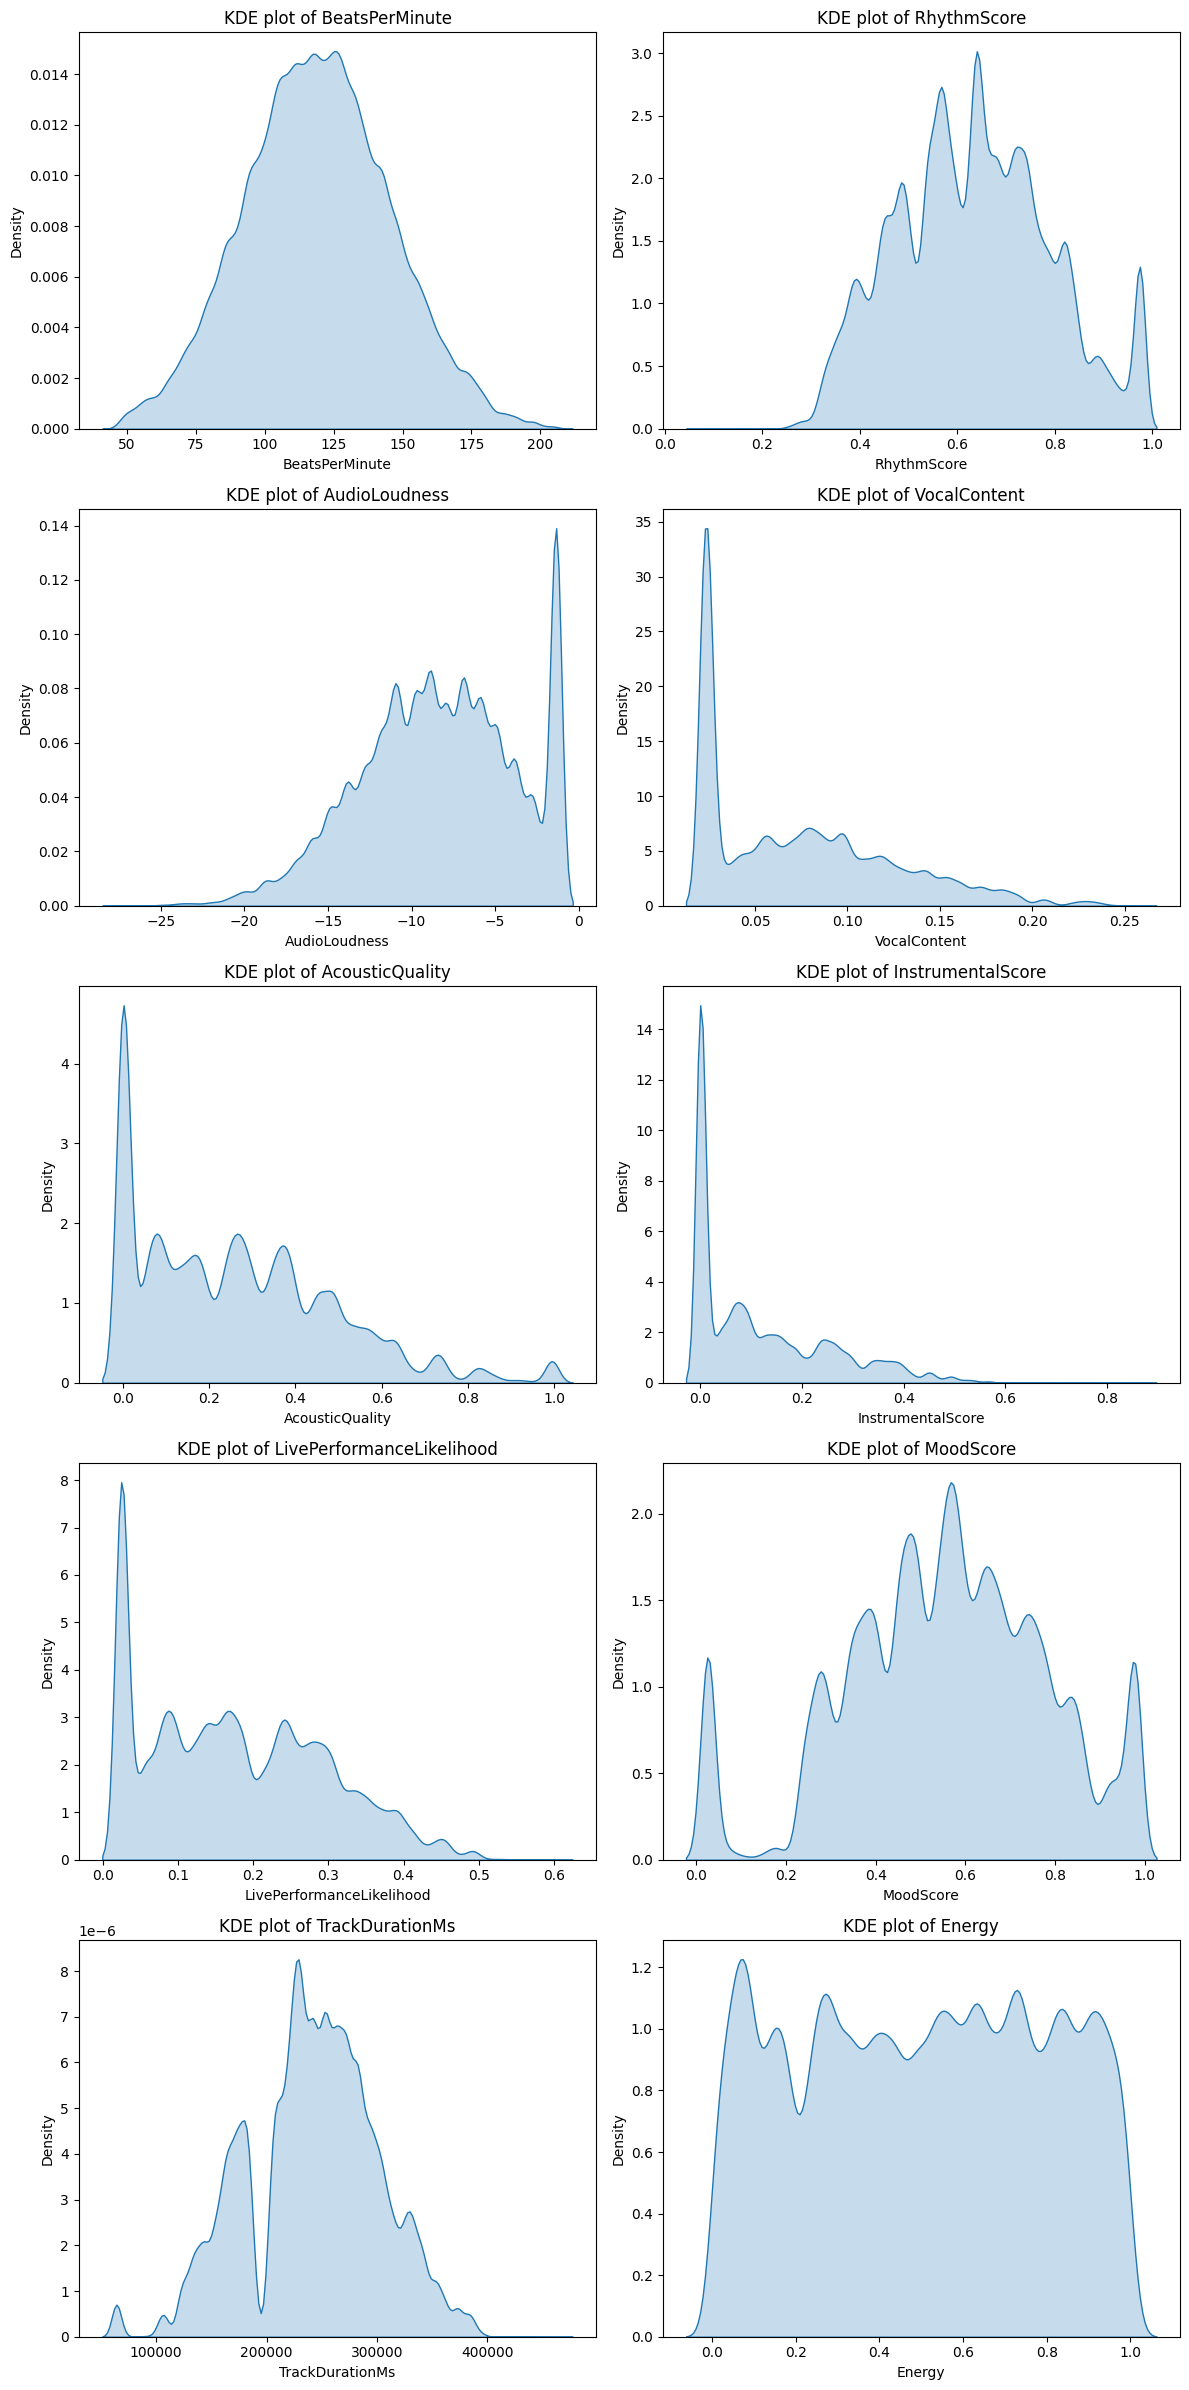

In [4]:
# KDE plots of target variable and numerical features
plt.figure(figsize=(12, 24))
kdeplot_col_names = [target_col]
kdeplot_col_names.extend(numeric_col_names)
for i, col in enumerate(kdeplot_col_names, start=1):
    plt.subplot(5, 2, i)
    sns.kdeplot(data=train_data, x=col, fill=True)
    plt.tight_layout()
    plt.title(f"KDE plot of {col}")

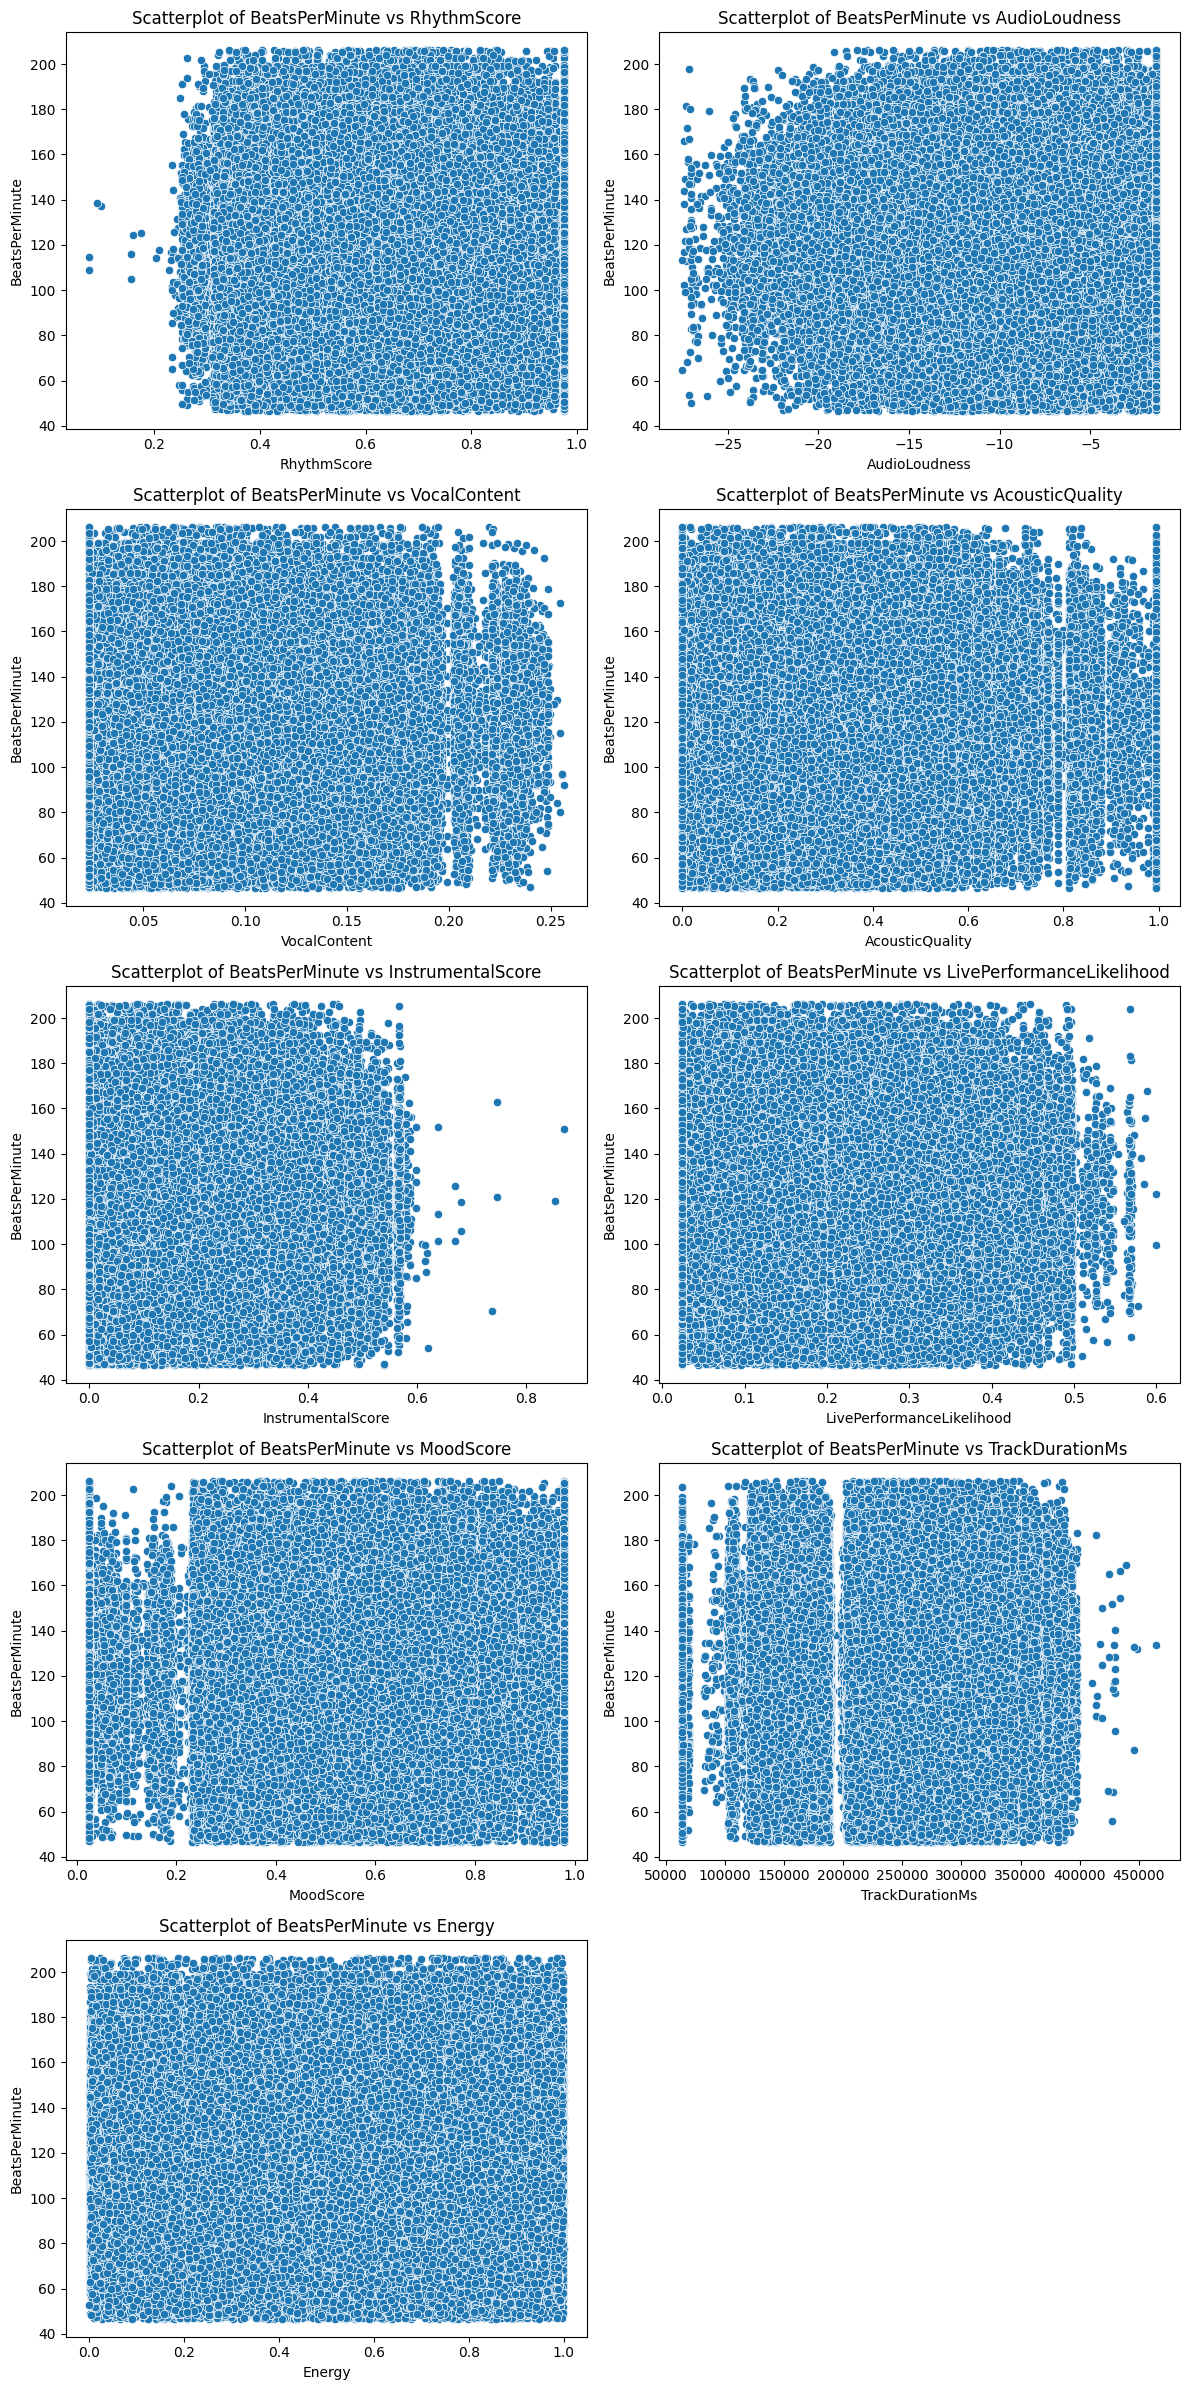

In [5]:
plt.figure(figsize=(12, 24))
for i, col in enumerate(numeric_col_names, start=1):
    plt.subplot(5, 2, i)
    sns.scatterplot(data=train_data, x=col, y="BeatsPerMinute")
    plt.tight_layout()
    plt.title(f"Scatterplot of BeatsPerMinute vs {col}")

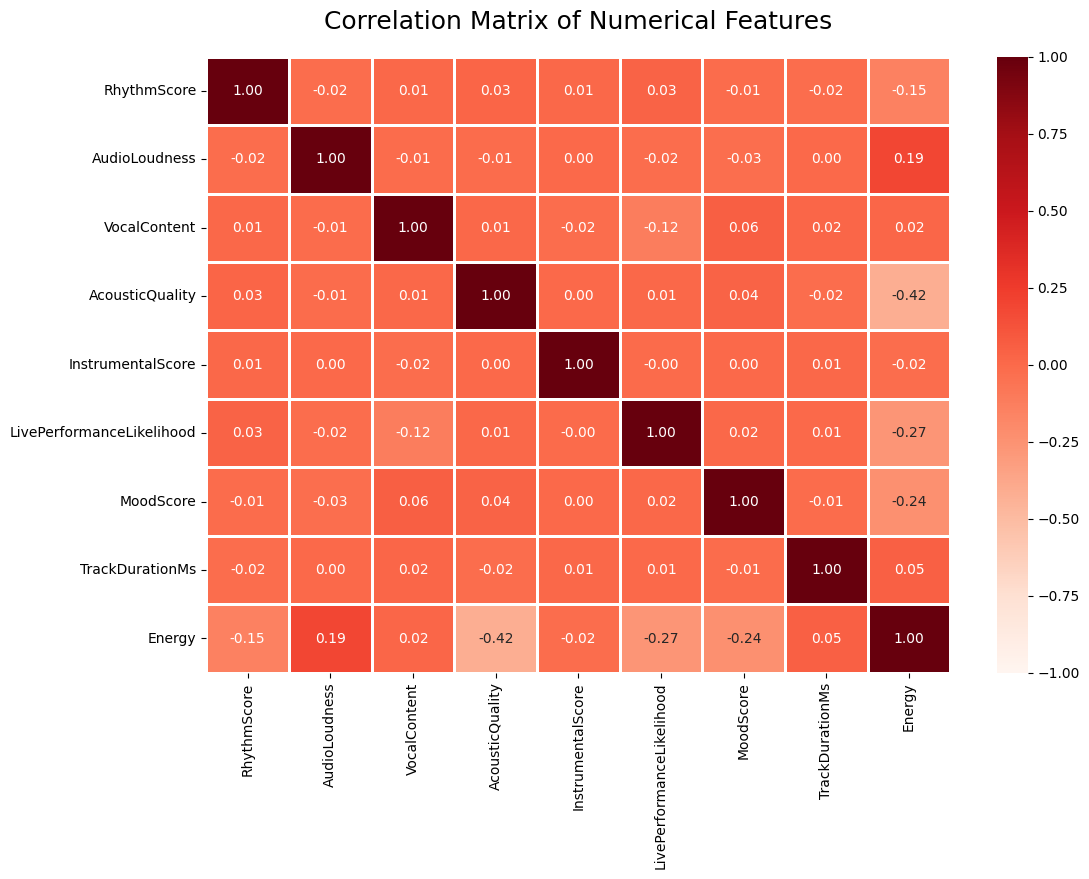

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_data[numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

# 4. Initial Setup for Stacking

We'll use stacking, an [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) strategy, to generate the predictions. As we'll need to gather predictions from various base models (a.k.a. level-0 models) to feed as input features to a meta model (a.k.a. level-1 model), in order to streamline the process of experimenting with different combinations of base models, some helper classes will be defined in this section. These classes can also be found [here](https://github.com/chuo-v/machine-learning-utils/blob/master/ensemble-learning/stacking/stacking_predictions_retriever.py) at one of my GitHub repositories used to organize some utilities I implemented for machine learning.

In [7]:
class StackingEstimator:
    """
    A class representing an estimator that will be used for stacking, an ensemble learning strategy.

    Intended to be used in conjunction with the `StackingPredictionsRetriever` class, which helps
    retrieve predictions for multiple instances of `StackingEstimator`; as the predictions are saved
    in files, on subsequent requests to retrieve predictions, even as the set of estimators has been
    modified, the `StackingPredictionsRetriever` class can determine the predictions of estimators
    that are non-stale and available (if any) by using the `get_hash` method of the `StackingEstimator`
    class to determine the relevance and staleness of any saved predictions.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimator are determinstic, i.e. they are exactly the same everytime the estimator is
    run with the same inputs (`name`, `params_dict`, `feature_names`, `get_predictions`).
    """
    name = ""
    params_dict = {}
    feature_names = []
    get_predictions = lambda: None

    def __init__(
        self,
        name: str,
        feature_names: [str],
        params_dict: {},
        get_preds: FunctionType
    ):
        """
        Initializes a new instance of `StackingEstimator`.

        :param name:
            A string representing a name for the estimator. It is used for the column names of
            the training and test predictions for each estimator, and is also used as an input
            to calculate a hash value for the estimator. It is recommended to use a different
            name from the names used for other estimators passed to `StackingPredictionsRetriever`.
        :param feature_names:
            A list of strings representing the names of the features that will be used for the
            estimator. It will be passed as an argument to `get_preds`. Internally, it is only
            used as an input to calculate a hash value for the estimator.
        :param params_dict:
            A dictionary of parameters that will be specified for the estimator. It will be
            passed as an argument to `get_preds`. Internally, it is only used as an input
            to calculate a hash value for the estimator.
        :param get_preds:
            A function for getting the predictions for the estimator. It should only take two
            arguments: 'params_dict' and 'feature_names', and should return predictions for
            the training and test data (in that order) as a tuple of two `pandas.Series`.
        """
        # parameter check
        if not isinstance(name, str):
            raise ValueError("`name` argument should be of type `str`")
        if not isinstance(feature_names, list):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should be of type `list`")
        elif not all(isinstance(feature_name, str) for feature_name in feature_names):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should only contain instances of `str`")
        if not isinstance(params_dict, dict):
            raise ValueError(f"`params_dict` argument for estimator \"{name}\" should be of type `dict`")
        get_preds_params = inspect.signature(get_preds).parameters.values()
        get_preds_param_names = [param.name for param in get_preds_params]
        if len(get_preds_param_names) != 2:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take two arguments")
        elif "params_dict" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"params_dict\" argument")
        elif "feature_names" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"feature_names\" argument")

        self.name = name
        self.feature_names = feature_names
        self.params_dict = params_dict
        self.get_preds = get_preds

    def get_hash_value(self):
        """
        Calculates and returns a hash value for the estimator using
        `name`, `feature_names` and `params_dict` as inputs.
        """
        feature_names_str = "_".join(sorted(self.feature_names))
        params_dict_str = "_".join(f"{key}-{value}" for (key, value) in sorted(self.params_dict.items()))
        hash_input_str = "_".join([self.name, feature_names_str, params_dict_str])
        md5_hash = hl.md5(hash_input_str.encode('utf-8')).hexdigest()
        return md5_hash

class StackingPredictionsRetriever:
    """
    A class for streamlining stacking (an ensemble learning strategy) that saves predictions
    from estimators to file so that when trying out different combinations of (base) estimators,
    the predictions that are not stale can be reused, saving the time of having the estimators
    make predictions again.

    Intended to be used in conjunction with the `StackingEstimator` class. The `hash_value` of
    `StackingEstimator` is used to determine the staleness and relevance of the predictions for
    an estimator. The implementation for making predictions using an estimator needs to be
    provided as a function to `get_preds` for `StackingEstimator`; when predictions need to be
    made using an estimator, this class will call `get_preds` for the `StackingEstimator` instance.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimators are determinstic, i.e. they are exactly the same everytime a
    `StackingEstimator` instance is run with the same inputs.
    """
    estimators = []
    working_dir_path = ""
    train_preds_filename = ""
    test_preds_filename = ""
    preds_save_interval = 0

    def __init__(
        self,
        estimators: [StackingEstimator],
        working_dir_path: str,
        train_preds_filename: str = "train_preds",
        test_preds_filename: str = "test_preds",
        preds_save_interval: int = 5,
    ):
        """
        Initializes a new instance of `StackingPredictionsRetriever`.

        :param estimators:
            A list of `StackingEstimator` instances for which the class will retrieve predictions.
        :param working_dir_path:
            The path for the working directory where the files with predictions will be saved.
        :param train_preds_filename:
            The name of the file in which predictions for the training set will be stored.
        :param test_preds_filename:
            The name of the file in which predictions for the test set will be stored.
        :param preds_save_interval:
            An integer which specifies the interval at which predictions will be saved when
            `get_preds` is called, corresponding to the number of estimators whose predictions
            have been retrieved since the predictions were previously saved. Any estimators
            whose predictions are not stale and therefore were not required to make predictions
            again are not included in this number.
        """
        # parameter check
        if not isinstance(estimators, list):
            raise ValueError("`estimators` must be passed as a list")
        if not all(isinstance(e, StackingEstimator) for e in estimators):
            raise ValueError("`estimators` should only contain instances of `StackingEstimator`")
        if not isinstance(working_dir_path, str):
            raise ValueError("`working_dir_path` argument should be of type `str`")
        if not isinstance(preds_save_interval, int):
            raise ValueError("`preds_save_interval` argument should be of type `int`")

        self.estimators = estimators
        self.working_dir_path = working_dir_path
        self.train_preds_filename = train_preds_filename
        self.test_preds_filename = test_preds_filename
        self.preds_save_interval = preds_save_interval

    def get_train_preds_file_path(self):
        """
        Returns the file path for storing predictions for training data.
        """
        return Path(f"{self.working_dir_path}/{self.train_preds_filename}.csv")

    def get_test_preds_file_path(self):
        """
        Returns the file path for storing predictions for test data.
        """
        return Path(f"{self.working_dir_path}/{self.test_preds_filename}.csv")

    def get_current_train_and_test_preds(self):
        """
        Returns the current predictions for training and test data (in that order)
        as a tuple of two `pandas.DataFrame`.

        The predictions are attempted to be retrieved from the file paths returned
        by `get_train_preds_file_path` and `get_test_preds_file_path`; if there are
        any issues with doing so (e.g. file does not exist, dataframe is empty),
        empty dataframes will be returned instead.
        In the case an `pandas.errors.EmptyDataError` exception is raised when
        reading from a file, the corresponding file will be removed.
        """
        curr_train_preds = pd.DataFrame()
        curr_test_preds = pd.DataFrame()
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            try:
                curr_train_preds = pd.read_csv(train_preds_file_path)
            except pd.errors.EmptyDataError:
                train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            try:
                curr_test_preds = pd.read_csv(test_preds_file_path)
            except pd.errors.EmptyDataError:
                test_preds_file_path.unlink()

        return curr_train_preds, curr_test_preds

    def get_preds(self):
        """
        Retrieves predictions from all estimators in `estimators`, storing them in
        two files at the file paths specified by `working_dir_path`,
        `train_preds_filename` and `test_preds_filename`.

        If non-stale (relevant) predictions are found for an estimator, retrieval
        of predictions by calling `get_preds` on the estimator will be skipped,
        and the existing predictions for the estimator will be kept.
        """
        print("[INFO] Getting predictions..")
        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        preds_retrieved_count = 0
        num_preds_retrieved_but_not_yet_saved = 0
        estimators_skipped = []

        for estimator in self.estimators:
            estimator_hash_value = estimator.get_hash_value()
            estimator_name = f"{estimator.name} ({estimator_hash_value})"

            # skip retrieving predictions for estimator if non-stale predictions are already available
            train_preds_available = any(estimator_hash_value in col_name for col_name in curr_train_preds.columns)
            test_preds_available = any(estimator_hash_value in col_name for col_name in curr_test_preds.columns)
            if train_preds_available and test_preds_available:
                estimators_skipped += [estimator_name]
                continue

            print(f"[INFO] Getting predictions for estimator {estimator_name}")
            train_preds, test_preds = estimator.get_preds(estimator.params_dict, estimator.feature_names)
            if not isinstance(train_preds, pd.core.series.Series):
                raise ValueError("`train_preds` should be of type `pandas.Series`")
            if not isinstance(test_preds, pd.core.series.Series):
                raise ValueError("`test_preds` should be of type `pandas.Series`")
            curr_train_preds[estimator_name] = train_preds
            curr_test_preds[estimator_name] = test_preds
            preds_retrieved_count += 1

            # save predictions at an interval of `preds_save_interval`
            if preds_retrieved_count % self.preds_save_interval == 0:
                curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
                curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
                num_preds_retrieved_but_not_yet_saved = 0
                print("[INFO] Saved predictions")
            else:
                num_preds_retrieved_but_not_yet_saved += 1

        if estimators_skipped:
            estimators_skipped.sort()
            formatted_estimators = ", ".join(estimators_skipped)
            print(f"[INFO] Skipped retrieving predictions for following estimators as their current ones are not stale:\n{formatted_estimators}")

        if num_preds_retrieved_but_not_yet_saved != 0:
            curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
            curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
            print("[INFO] Saved predictions")

        print("[INFO] Finished getting all predictions")

    def sync_preds(self):
        """
        Syncs the predictions stored at the two file paths specified by
        `working_dir_path`, `train_preds_filename` and `test_preds_filename` by
        removing predictions for any estimator that is not currently in `estimators`.

        Note that new predictions for estimators that do not currently have predictions
        in the files will not be added; `get_preds` should be used for this purpose
        instead.
        """
        print("[INFO] Syncing predictions..")
        estimator_hash_values = [estimator.get_hash_value() for estimator in self.estimators]
        should_remove_col = lambda col_name: not any(hash_value in col_name for hash_value in estimator_hash_values)

        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        if not curr_train_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_train_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from training predictions:\n{col_names_to_remove}")
                curr_train_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_train_preds.to_csv(self.get_train_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for training predictions were dropped")
        if not curr_test_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_test_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from test predictions:\n{col_names_to_remove}")
                curr_test_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_test_preds.to_csv(self.get_test_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for training predictions were dropped")

        print("[INFO] Finished syncing predictions")

    def clear_preds(self):
        """
        Removes all stored predictions by deleting the two files at filepaths specified
        by `working_dir_path`, `train_preds_filename` and `test_preds_filename`.
        """
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            test_preds_file_path.unlink()

        print("[INFO] Finished clearing predictions")

Next, we'll simply create a variable for storing the estimators (`StackingEstimator` instances) that we'll pass to the `StackingPredictionsRetriever` class for getting all the predictions from our base models.

In [8]:
estimators = []